<a href="https://colab.research.google.com/github/xDevICCI/TallerDeepLearning/blob/main/VictorGodoy_XXXXXXXXX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color='red'>WARNING-1: No se aceptan soluciones que usen metodologías distintas a las vistas en clases.</font>

<font color='orange'>Está permitido usar los códigos de los ejemplos vistos en clases.</font>



# 0) Cambiar el nombre del archivo

<font color='red'>WARNING-2: CAMBIA EL NOMBRE DEL ARCHIVO ipynb INCLUYENDO TU NOMBRE Y RUT</font>

Ejemplo, si tu nombres es Pedro Perez y RUT es 12.345.678-9, el nombre de este archivo debe cambiarse de "Nombre_Rut.ipynb" a "Pedro_Perez_12345678-9.ipynb"


🏷️ Nombre del proyecto:
# Predicción de Fallas y Retrasos en Manufactura con LSTM

# 📊 Descripción del dataset y problema a resolver:

Este proyecto aborda un problema de clasificación multiclase en un entorno de manufactura híbrida. A partir de un conjunto de datos que contiene información de trabajos asignados a distintas máquinas (incluyendo tipo de operación, material utilizado, tiempos programados y reales, consumo energético y estado final del trabajo), se busca predecir el campo Job_Status, que puede tomar los siguientes valores:

- Completed: el trabajo se ejecutó correctamente dentro del rango esperado.
- Delayed: el trabajo se ejecutó pero con retrasos respecto al plan.
- Failed: el trabajo no se completó o tuvo problemas críticos.

La solución se implementará utilizando modelos de Deep Learning como redes LSTM o Multilayer Perceptrons (MLP) para identificar patrones en los datos que permitan anticipar fallos y retrasos antes de que ocurran.

# 1) Carga de datos y librerías a utilizar

(2 puntos)

Incluya aquí todas las librerías a utilizar en este código.

De una ubicación de los datos para ser descargados.

Por ejemplo: Los datos se encuentran en `https://www.dropbox.com/s/p94odo87ekacd46/bikes3.zip`




In [ ]:
!pip install tensorflow

In [1]:
# ===============================
# Capítulo 1: Configuración inicial
# ===============================

# Librerías base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y modelado
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Configuración global
SEED = 42
np.random.seed(SEED)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2) Definición de parámetros

(1 punto)

Defina los parámetros necesarios. Por ejemplo: `fpath` (path de los archivos), `BATCH_SIZE`, etc.



In [3]:
# Ruta del archivo
fpath = "sample_data/hybrid_manufacturing_categorical.csv"

# Parámetros del modelo
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001
SEED = 42
TEST_SIZE = 0.2


# 3) Pre-procesamiento y Data augmentation (si es necesario, investigue métodos para el aumento de los datos artificialente)

(2 puntos)

Defina los parámetros necesarios, haga los cambios necesarios considerando el tamaño de las imágenes, señales, etc.



In [3]:
# ===============================
# Capítulo 3.1: Carga y limpieza de datos
# ===============================

# Cargar dataset
ruta = "sample_data/hybrid_manufacturing_categorical.csv"
df = pd.read_csv(ruta)

# Conversión de fechas
fechas = ["Scheduled_Start", "Scheduled_End", "Actual_Start", "Actual_End"]
for f in fechas:
    df[f] = pd.to_datetime(df[f], errors='coerce')

# Crear duraciones
df["sched_duration"] = (df["Scheduled_End"] - df["Scheduled_Start"]).dt.total_seconds() / 60
df["exec_duration"] = (df["Actual_End"] - df["Actual_Start"]).dt.total_seconds() / 60

df["delay_minutes"] = df["exec_duration"] - df["sched_duration"]

# Eliminar fechas originales
df.drop(columns=fechas, inplace=True)

# Validar nulos
assert df.isnull().sum().sum() > 0, "No hay nulos para imputar"

Distribución de clases:
Job_Status
Completed    673
Delayed      198
Failed       129
Name: count, dtype: int64


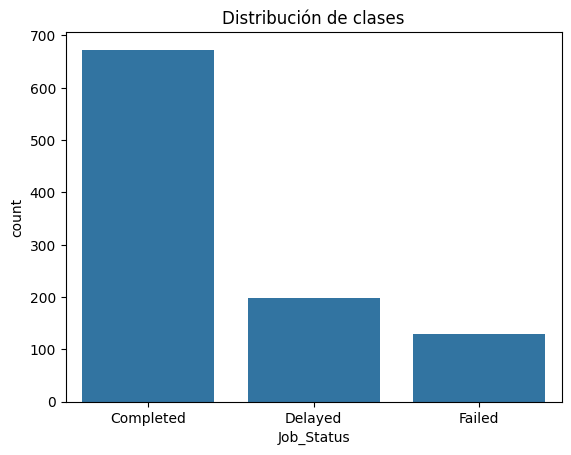

LinAlgError: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

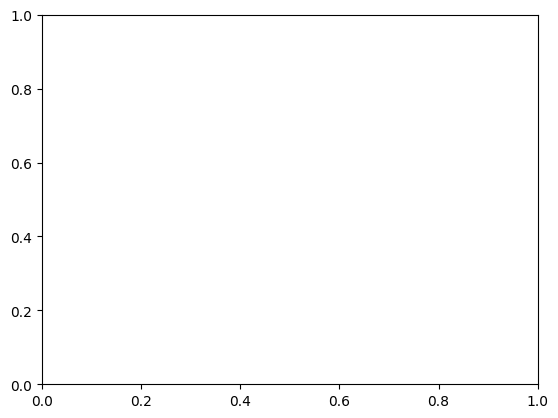

In [4]:
# ===============================
# Capítulo 3.2: Exploración de datos
# ===============================

print("Distribución de clases:")
print(df["Job_Status"].value_counts())

sns.countplot(data=df, x="Job_Status")
plt.title("Distribución de clases")
plt.show()

sns.histplot(data=df, x="delay_minutes", hue="Job_Status", kde=True)
plt.title("Distribución de retrasos")
plt.show()

In [5]:
# ===============================
# Capítulo 3.3: Preprocesamiento con holdout
# ===============================

# Definir X e y
y = df["Job_Status"]
X = df.drop(columns=["Job_ID", "Job_Status"])

# Separar test final
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

# Sacar 20 ejemplos por clase como holdout
df_train_full = X_train_full.copy()
df_train_full["Job_Status"] = y_train_full

df_holdout = pd.concat([
    df_train_full[df_train_full["Job_Status"] == c].sample(n=20, random_state=SEED)
    for c in df_train_full["Job_Status"].unique()
])

df_train_final = df_train_full.drop(index=df_holdout.index)
X_train = df_train_final.drop(columns="Job_Status")
y_train = df_train_final["Job_Status"]
X_holdout = df_holdout.drop(columns="Job_Status")
y_holdout = df_holdout["Job_Status"]

# Columnas categóricas y numéricas
cat_cols = ["Machine_ID", "Operation_Type", "Optimization_Category"]
num_cols = [col for col in X.columns if col not in cat_cols]

# Pipelines
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

pre = ColumnTransformer([
    ("cat", cat_pipe, cat_cols),
    ("num", num_pipe, num_cols)
])

# Fit-transform
X_train_proc = pre.fit_transform(X_train)
X_test_proc = pre.transform(X_test)
X_holdout_proc = pre.transform(X_holdout)

# Validación de nulos
assert not np.isnan(X_train_proc).any()
assert not np.isnan(X_test_proc).any()
assert not np.isnan(X_holdout_proc).any()

# 5) Entrenar el modelo

(4 puntos)

Entre el modelo definido en los pasos anteriores

In [7]:
# ===============================
# Capítulo 5: Definición y entrenamiento del modelo
# ===============================

def build_model(input_dim, n_classes):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [8]:
# ===============================
# Capítulo 5.1: Comparación entre variantes
# ===============================

le = LabelEncoder().fit(y)
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)
y_holdout_enc = le.transform(y_holdout)

# Variante A: baseline sin balanceo
model_a = build_model(X_train_proc.shape[1], len(le.classes_))
hist_a = model_a.fit(X_train_proc, y_train_enc, validation_split=0.2, epochs=50, batch_size=32, verbose=0)

# Variante B: SMOTE
smote = SMOTE(random_state=SEED)
X_train_sm, y_train_sm = smote.fit_resample(X_train_proc, y_train_enc)
model_b = build_model(X_train_sm.shape[1], len(le.classes_))
hist_b = model_b.fit(X_train_sm, y_train_sm, validation_split=0.2, epochs=50, batch_size=32, verbose=0)

# Variante C: class_weight
cw = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_enc), y=y_train_enc)
cw_dict = {i: w for i, w in enumerate(cw)}
model_c = build_model(X_train_proc.shape[1], len(le.classes_))
hist_c = model_c.fit(X_train_proc, y_train_enc, validation_split=0.2, epochs=50, batch_size=32, verbose=0, class_weight=cw_dict)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# 6) Evaluación de desempeño

(2 puntos)

Calcule el accuracy en el training, validation y testing.

In [9]:
# ===============================
# Capítulo 6: Evaluación comparativa
# ===============================

def evaluar_modelo(nombre, modelo, X_test, y_test):
    y_pred = modelo.predict(X_test).argmax(axis=1)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    delayed_idx = np.where(le.classes_ == 'Delayed')[0][0] if 'Delayed' in le.classes_ else None
    if delayed_idx is not None:
        recall = classification_report(y_test, y_pred, output_dict=True)[str(delayed_idx)]['recall']
    else:
        recall = 0.0

    return {"Modelo": nombre, "Accuracy": acc, "F1_macro": f1, "Recall_Delayed": recall}

resumen = []
resumen.append(evaluar_modelo("Baseline", model_a, X_test_proc, y_test_enc))
resumen.append(evaluar_modelo("SMOTE", model_b, X_test_proc, y_test_enc))
resumen.append(evaluar_modelo("Class Weight", model_c, X_test_proc, y_test_enc))

resultados_df = pd.DataFrame(resumen)
print("\n📊 Comparación de Modelos:")
display(resultados_df.sort_values("F1_macro", ascending=False))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

📊 Comparación de Modelos:


,Modelo,Accuracy,F1_macro,Recall_Delayed
2,Class Weight,0.710,0.702052,0.775
1,SMOTE,0.680,0.661308,0.450
0,Baseline,0.685,0.611154,0.275


# 7) Evaluación aleatoria (de una imagen, señal etc.) del testing

(1 punto)

Despliegue una señal, imagen, cadena de texto, etc.,  aleatoria del testing con la clasificación proporcionada por el Transformer entrenado.

APRENDIZAJE MODELO SMOTE

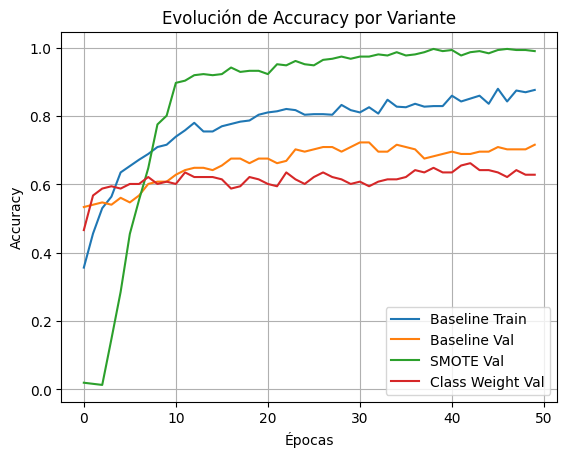

In [10]:
plt.plot(hist_a.history['accuracy'], label='Baseline Train')
plt.plot(hist_a.history['val_accuracy'], label='Baseline Val')
plt.plot(hist_b.history['val_accuracy'], label='SMOTE Val')
plt.plot(hist_c.history['val_accuracy'], label='Class Weight Val')
plt.title("Evolución de Accuracy por Variante")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


🔵 Baseline (Train vs Val):
La línea azul (train) sube de forma continua y se estabiliza cerca de ~0.85.
La línea naranja (val) se queda entre 0.65 y 0.70.
**Esto indica overfitting: el modelo aprende el set de entrenamiento pero no logra generalizar tan bien.**

🟢 SMOTE (Val):
Sube rápidamente y alcanza valores cercanos a 1.0 de accuracy en validación.
Aunque eso parece bueno, es sospechoso: puede estar sobreajustando al set de validación balanceado sintéticamente.
Verifica si esta validación viene del validation_split=0.2 aplicado sobre los datos ya aumentados por SMOTE (¡lo cual no refleja la distribución real!).

In [ ]:
# Variante B: SMOTE (solo para entrenar, validación externa real)
smote = SMOTE(random_state=SEED)
X_train_sm, y_train_sm = smote.fit_resample(X_train_proc, y_train_enc)

model_b = build_model(X_train_sm.shape[1], len(le.classes_))
model_b.fit(X_train_sm, y_train_sm, epochs=50, batch_size=32, verbose=0)  # sin validation_split

# Evaluación externa real (test o holdout)
from sklearn.metrics import classification_report

y_pred_b = model_b.predict(X_test_proc).argmax(axis=1)
print(classification_report(y_test_enc, y_pred_b, target_names=le.classes_))


In [ ]:
import shap
explainer = shap.KernelExplainer(model.predict, X_train_sm[:100])
shap_values = explainer.shap_values(X_test_proc[:50])
shap.summary_plot(shap_values, X_test_proc[:50], feature_names=pre.get_feature_names_out())


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
